# Import bibliotek

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling
import plotly
import plotly.graph_objs as go
import plotly.plotly as py
import plotly.tools as tls
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Ustawimy wyświetlanie wykresów w arkuszu jupyter notebook i ustawmy ich rozmiar na większy.

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (25,15)

Jeżeli biblioteki nie działają proponujemy zainstalować je bezpośrednio poprzez jupyter notebook jak poniżej:

In [ ]:
!pip install --user pandas==0.23.0

Logowanie do plotly:

In [5]:
plotly.tools.set_credentials_file(username='iza08.ik', api_key='lr02By0LM9Ofjctmhc3T')

# Odpowiednie przygotowanie danych 

## Wczytanie danych

In [6]:
dane_proba = pd.read_csv('../dane/Weather.csv', sep=',')
dane_proba.head()

Unnamed: 0      city        date  year  month  day  high_temp  avg_temp  \
0           1  Auckland  2016-01-01  2016      1    1         68        65   
1           2  Auckland  2016-01-02  2016      1    2         68        66   
2           3  Auckland  2016-01-03  2016      1    3         77        72   
3           4  Auckland  2016-01-04  2016      1    4         73        66   
4           5  Auckland  2016-01-05  2016      1    5         69        62   

   low_temp  high_dewpt  ...  avg_hg  low_hg  high_vis  avg_vis  low_vis  \
0        62          64  ...   30.09   30.01         6        6        4   
1        64          64  ...   29.90   29.80         6        5        1   
2        66          70  ...   29.73   29.68         6        6        1   
3        60          66  ...   29.90   29.77         6        6        6   
4        55          55  ...   30.14   30.09         6        6        6   

   high_wind  avg_wind  low_wind  precip  events  
0         21        15      28.0       0    Rain  
1         33        21      46.0       0    Rain  
2         18        12       NaN       0    Rain  
3         15        10       NaN       0    Rain  
4         13         7       NaN       0     NaN  

[5 rows x 26 columns]

Zauważamy, niepotrzebną kolumnę z numeracją obserwacji. Usuńmy ją.

In [7]:
dane = dane_proba.iloc[:, 1:dane_proba.shape[1]]

## Przyjrzyjmy się danym

In [8]:
dane.head()

city        date  year  month  day  high_temp  avg_temp  low_temp  \
0  Auckland  2016-01-01  2016      1    1         68        65        62   
1  Auckland  2016-01-02  2016      1    2         68        66        64   
2  Auckland  2016-01-03  2016      1    3         77        72        66   
3  Auckland  2016-01-04  2016      1    4         73        66        60   
4  Auckland  2016-01-05  2016      1    5         69        62        55   

   high_dewpt  avg_dewpt  ...  avg_hg  low_hg  high_vis  avg_vis  low_vis  \
0          64         60  ...   30.09   30.01         6        6        4   
1          64         63  ...   29.90   29.80         6        5        1   
2          70         67  ...   29.73   29.68         6        6        1   
3          66         60  ...   29.90   29.77         6        6        6   
4          55         52  ...   30.14   30.09         6        6        6   

   high_wind  avg_wind  low_wind  precip  events  
0         21        15      28.0       0    Rain  
1         33        21      46.0       0    Rain  
2         18        12       NaN       0    Rain  
3         15        10       NaN       0    Rain  
4         13         7       NaN       0     NaN  

[5 rows x 25 columns]

### Wyświetlenie etykiet kolumn

In [9]:
dane.columns

Index(['city', 'date', 'year', 'month', 'day', 'high_temp', 'avg_temp',
       'low_temp', 'high_dewpt', 'avg_dewpt', 'low_dewpt', 'high_humidity',
       'avg_humidity', 'low_humidity', 'high_hg', 'avg_hg', 'low_hg',
       'high_vis', 'avg_vis', 'low_vis', 'high_wind', 'avg_wind', 'low_wind',
       'precip', 'events'],
      dtype='object')

### Wyświetlenie typów danych

In [10]:
dane.dtypes

city              object
date              object
year               int64
month              int64
day                int64
high_temp          int64
avg_temp           int64
low_temp           int64
high_dewpt         int64
avg_dewpt          int64
low_dewpt          int64
high_humidity      int64
avg_humidity       int64
low_humidity       int64
high_hg          float64
avg_hg           float64
low_hg           float64
high_vis           int64
avg_vis            int64
low_vis            int64
high_wind          int64
avg_wind           int64
low_wind         float64
precip            object
events            object
dtype: object

Zauważamy, że zmienna precip opisująca ilość opadów z niewiadomego powodu jest typu object, czego zagadka w dalszej części analizy zostanie rozwiązana a problem naprawiony.

### Zliczenie wartości NaN w danych

In [11]:
dane.isna().sum()

city                0
date                0
year                0
month               0
day                 0
high_temp           0
avg_temp            0
low_temp            0
high_dewpt          0
avg_dewpt           0
low_dewpt           0
high_humidity       0
avg_humidity        0
low_humidity        0
high_hg             0
avg_hg              0
low_hg              0
high_vis            0
avg_vis             0
low_vis             0
high_wind           0
avg_wind            0
low_wind         1326
precip              0
events           2217
dtype: int64

W dalszej części analizy przyjrzmy się, co powoduje braki danych i poradzimy sobie z nimi.

### Wyświetlenie wymiaru danych

In [12]:
dane.shape

(3655, 25)

# Rozwiązanie zauważonych problemów z danymi

### Rozwiązanie problemu watości NaN

W kolumnie 'Events' wartość Nan zamieniłyśny na 'No event' - w ten sposób zakodowana jest informacja o braku szczególnych wydarzeń pogodowych

In [13]:
dane['events'] = dane['events'].fillna('No event')

Zamiana NaN w kolumnie dotyczącej pomiaru prędkości wiatru na 0.

In [14]:
dane['low_wind'] = dane['low_wind'].fillna(0)

### Utworzenie kolumn odpowiadającym pojedynczym wydarzeniom

Wyświetlenie unikalnych wartości w kolumnie events

In [15]:
dane['events'].unique()

array(['Rain', 'No event', 'Fog , Rain , Thunderstorm', 'Fog , Rain',
       'Rain , Thunderstorm', 'Rain , Hail', 'Fog', 'Thunderstorm',
       'Rain , Hail , Thunderstorm', 'Snow', 'Rain , Snow',
       'Fog , Thunderstorm', 'Fog , Snow', 'Fog , Rain , Snow',
       'Fog , Snow , Thunderstorm'], dtype=object)

Zobaczenie stosunku danych dla różnych typow zdarzeń

In [16]:
dane.events.value_counts()

No event                      2217
Rain                           910
Rain , Thunderstorm            229
Fog                            115
Snow                            66
Fog , Rain                      44
Thunderstorm                    18
Rain , Snow                     15
Fog , Snow                      12
Fog , Rain , Thunderstorm       10
Rain , Hail                      7
Rain , Hail , Thunderstorm       5
Fog , Rain , Snow                5
Fog , Thunderstorm               1
Fog , Snow , Thunderstorm        1
Name: events, dtype: int64

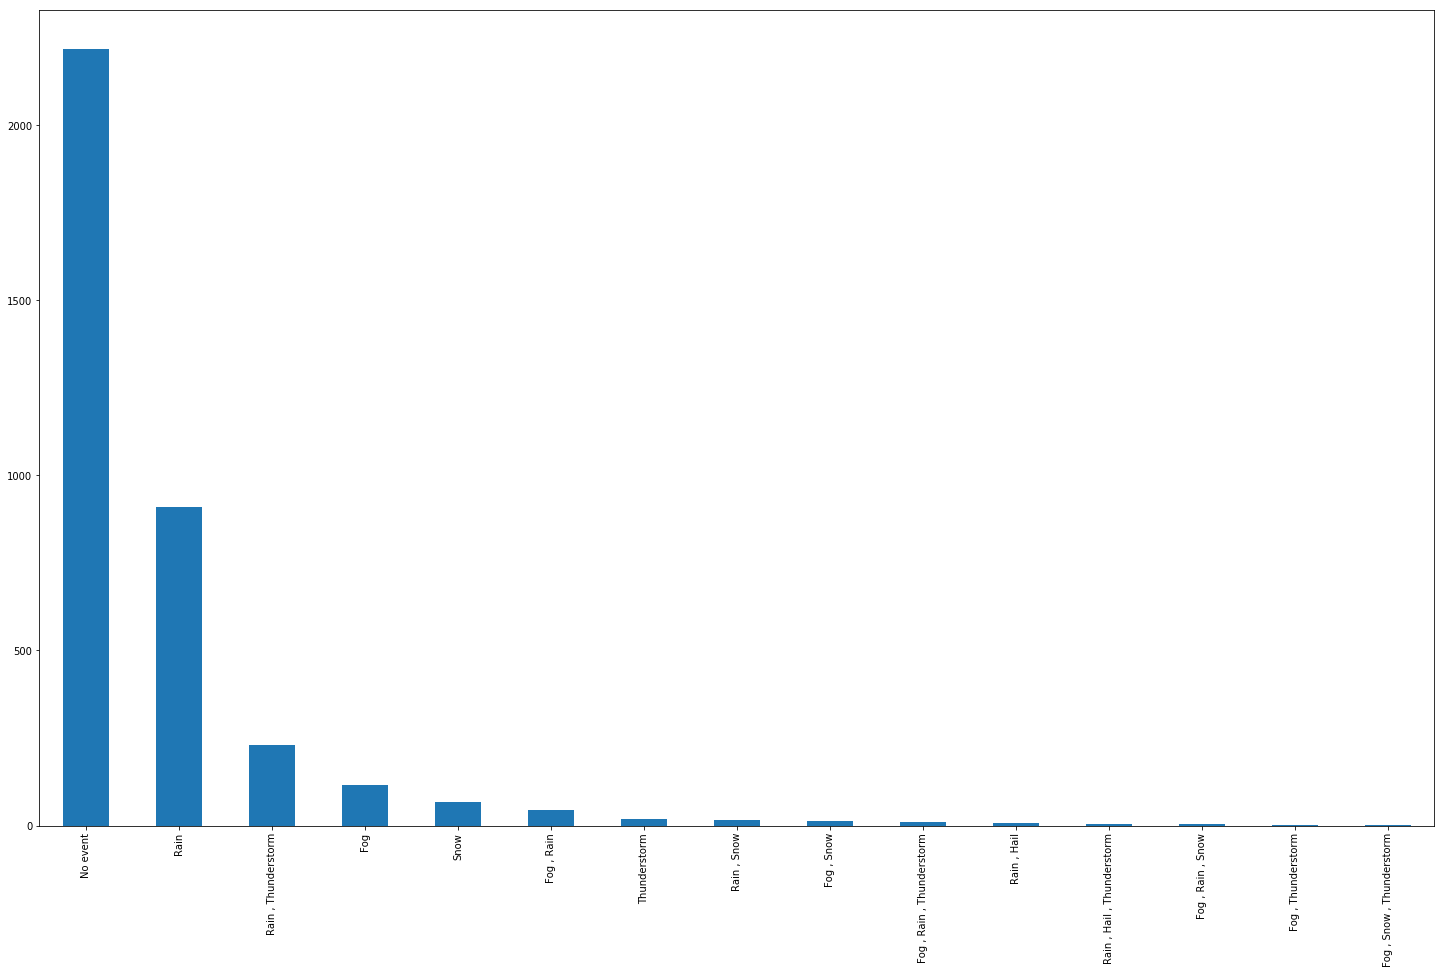

In [17]:
dane.events.value_counts().plot.bar()

Widzimy sporą dysproporcję danych, co może utrudniać dalszą analizę.

Niektóre wydarzenia występują tylko raz. W celu więc predykcji zignorujemy ewentualną korelację wydarzeń i osobno przewidzimy każde z nich.

Utworzenie nowych kolumn w celu dekompozycji wydarzeń na pojedyncze oraz późniejszych celów technik uczenia maszynowego

In [18]:
def create(x):
    dane[x] = dane['events']
    dane[x] = [i.find(x) for i in dane[x]]
    dane[x] = dane[x].map({-1: 0}).fillna(1)
    
create("Rain")
create("Fog")
create("Thunderstorm")
create("Snow")
create("Hail")

### Problemy z kolumną 'Precip'

Zauważyłyśmy też, że kolumna 'Precip', dotycząca ilości opadów jest w formacie object, zamiast inf lub float. Przeczytaliśmy opis kolumny. Okazało się, że zawiera ona oznaczenie 'T' na śladową ilość opadów, co może być problemem w dalszej analizie.

Zamiana 'T' (oznacza śladową ilość opadów) w kolumnie dotyczącej opady na niską wartość, niższą od występujących (min 0.007)   ale większą od 0 - wartość 0.001

In [19]:
dane['precip'] = dane['precip'].replace('T', 0.001)

Zmiana typu danych kolumny z ilością opadów oraz zobaczenie statystyk

In [20]:
dane['precip'] = pd.to_numeric(dane['precip'])
dane['precip'].describe()

count    3655.000000
mean        0.080909
std         0.436573
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        12.680000
Name: precip, dtype: float64

In [21]:
for city in pd.unique(dane.city):
    print(city)
    print(dane.iloc[:, 5:24][dane.city == city].describe()[1:2])
    print('\n')

Auckland
      high_temp   avg_temp   low_temp  high_dewpt  avg_dewpt  low_dewpt  \
mean  66.456908  60.616963  54.712722    57.93844  54.266758  50.373461   

      high_humidity  avg_humidity  low_humidity    high_hg     avg_hg  \
mean      95.228454     80.419973     63.109439  30.059097  29.980752   

         low_hg  high_vis   avg_vis   low_vis  high_wind  avg_wind  low_wind  \
mean  29.909152       6.0  5.946648  4.575923  17.856361  9.656635  7.240766   

      precip  
mean     0.0  


Mumbai
      high_temp   avg_temp   low_temp  high_dewpt  avg_dewpt  low_dewpt  \
mean  89.964432  80.937073  71.911081   74.344733  69.906977  64.344733   

      high_humidity  avg_humidity  low_humidity    high_hg    avg_hg  \
mean      84.593707     66.396717     44.863201  29.862353  29.79922   

        low_hg  high_vis   avg_vis   low_vis  high_wind  avg_wind   low_wind  \
mean  29.74015  2.704514  1.908345  0.942544  14.831737  6.088919  11.738714   

        precip  
mean  0.228577  




C:\ProgramData\anakio\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

C:\ProgramData\anakio\lib\site-packages\seaborn\categorical.py:3672: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



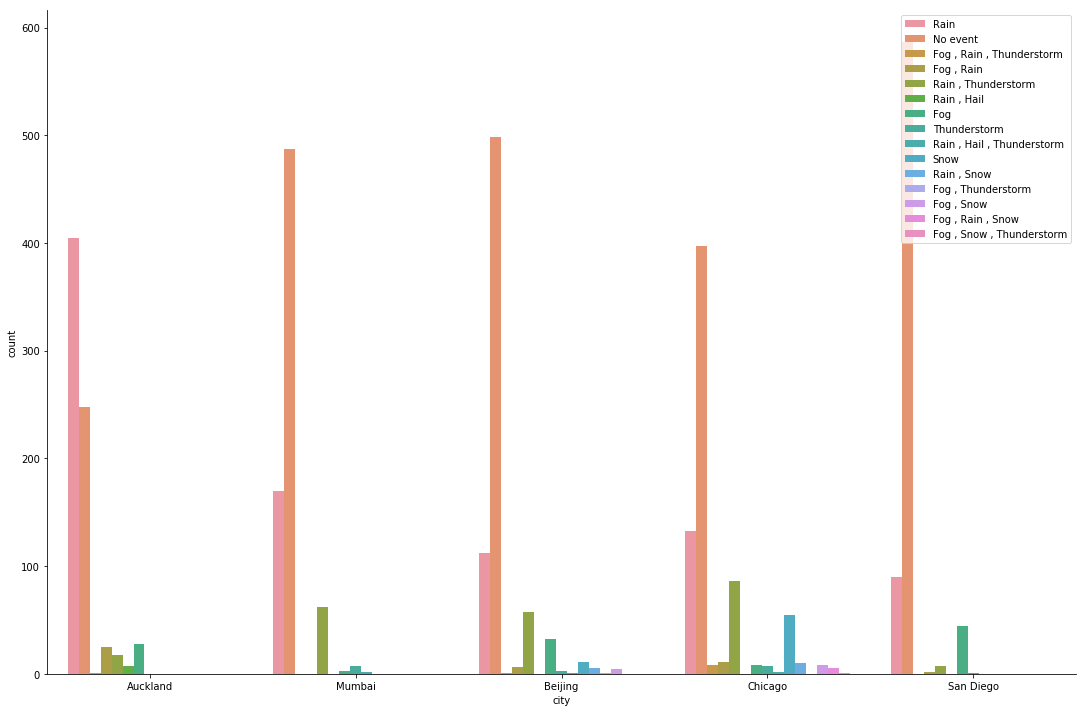

In [22]:
fig = sns.factorplot(x="city", 
                     hue="events", 
                     data=dane, 
                     kind='count',
                     size = 10,
                     aspect = 1.5,
                     legend=False)

fig.ax.legend(loc=1)

In [24]:
dane[dane.Snow == 1]

city        date  year  month  day  high_temp  avg_temp  low_temp  \
1477  Beijing  2016-01-16  2016      1   16         30        27        24   
1478  Beijing  2016-01-17  2016      1   17         25        16         8   
1482  Beijing  2016-01-21  2016      1   21         26        20        15   
1505  Beijing  2016-02-13  2016      2   13         39        31        23   
1519  Beijing  2016-02-27  2016      2   27         48        34        21   
1520  Beijing  2016-02-28  2016      2   28         44        32        19   
1786  Beijing  2016-11-20  2016     11   20         43        38        33   
1787  Beijing  2016-11-21  2016     11   21         33        28        24   
1816  Beijing  2016-12-20  2016     12   20         32        28        23   
1828  Beijing  2017-01-01  2017      1    1         32        26        19   
1832  Beijing  2017-01-05  2017      1    5         39        32        24   
1834  Beijing  2017-01-07  2017      1    7         39        34        30   
1842  Beijing  2017-01-15  2017      1   15         32        26        19   
1843  Beijing  2017-01-16  2017      1   16         32        29        26   
1846  Beijing  2017-01-19  2017      1   19         31        24        17   
1865  Beijing  2017-02-07  2017      2    7         36        30        23   
1879  Beijing  2017-02-21  2017      2   21         35        28        21   
1880  Beijing  2017-02-22  2017      2   22         44        32        21   
1910  Beijing  2017-03-24  2017      3   24         42        38        33   
2190  Beijing  2017-12-29  2017     12   29         29        22        14   
2193  Chicago  2016-01-01  2016      1    1         31        25        19   
2195  Chicago  2016-01-03  2016      1    3         29        26        22   
2196  Chicago  2016-01-04  2016      1    4         31        27        22   
2201  Chicago  2016-01-09  2016      1    9         40        32        23   
2202  Chicago  2016-01-10  2016      1   10         23        13         2   
2203  Chicago  2016-01-11  2016      1   11         24        12        -1   
2204  Chicago  2016-01-12  2016      1   12         20        12         3   
2205  Chicago  2016-01-13  2016      1   13         25        12        -2   
2212  Chicago  2016-01-20  2016      1   20         23        18        12   
2214  Chicago  2016-01-22  2016      1   22         30        25        19   
...       ...         ...   ...    ...  ...        ...       ...       ...   
2570  Chicago  2017-01-12  2017      1   12         28        24        19   
2583  Chicago  2017-01-25  2017      1   25         42        38        34   
2584  Chicago  2017-01-26  2017      1   26         34        32        30   
2585  Chicago  2017-01-27  2017      1   27         31        28        24   
2587  Chicago  2017-01-29  2017      1   29         28        25        21   
2588  Chicago  2017-01-30  2017      1   30         37        26        15   
2590  Chicago  2017-02-01  2017      2    1         38        30        21   
2614  Chicago  2017-02-25  2017      2   25         33        28        23   
2618  Chicago  2017-03-01  2017      3    1         54        43        32   
2619  Chicago  2017-03-02  2017      3    2         35        31        27   
2621  Chicago  2017-03-04  2017      3    4         42        35        28   
2629  Chicago  2017-03-12  2017      3   12         36        27        18   
2630  Chicago  2017-03-13  2017      3   13         30        28        27   
2631  Chicago  2017-03-14  2017      3   14         28        24        19   
2634  Chicago  2017-03-17  2017      3   17         50        43        36   
2872  Chicago  2017-11-10  2017     11   10         30        24        18   
2880  Chicago  2017-11-18  2017     11   18         48        42        35   
2899  Chicago  2017-12-07  2017     12    7         29        24        19   
2900  Chicago  2017-12-08  2017     12    8         37        28        18   
2901  Chicago  2017-12-09  2017

In [25]:
dane[dane.Rain == 1]

city        date  year  month  day  high_temp  avg_temp  low_temp  \
0      Auckland  2016-01-01  2016      1    1         68        65        62   
1      Auckland  2016-01-02  2016      1    2         68        66        64   
2      Auckland  2016-01-03  2016      1    3         77        72        66   
3      Auckland  2016-01-04  2016      1    4         73        66        60   
6      Auckland  2016-01-07  2016      1    7         71        66        60   
7      Auckland  2016-01-08  2016      1    8         77        70        64   
8      Auckland  2016-01-09  2016      1    9         69        66        64   
9      Auckland  2016-01-10  2016      1   10         71        66        62   
11     Auckland  2016-01-12  2016      1   12         69        66        62   
15     Auckland  2016-01-16  2016      1   16         78        68        59   
16     Auckland  2016-01-17  2016      1   17         78        72        66   
17     Auckland  2016-01-18  2016      1   18         77        72        68   
18     Auckland  2016-01-19  2016      1   19         75        68        62   
25     Auckland  2016-01-26  2016      1   26         80        72        64   
26     Auckland  2016-01-27  2016      1   27         77        73        69   
27     Auckland  2016-01-28  2016      1   28         78        73        68   
28     Auckland  2016-01-29  2016      1   29         77        72        68   
30     Auckland  2016-01-31  2016      1   31         80        73        66   
34     Auckland  2016-02-04  2016      2    4         77        70        64   
35     Auckland  2016-02-05  2016      2    5         75        70        66   
36     Auckland  2016-02-06  2016      2    6         78        72        66   
37     Auckland  2016-02-07  2016      2    7         80        74        68   
38     Auckland  2016-02-08  2016      2    8         75        70        66   
40     Auckland  2016-02-10  2016      2   10         78        72        66   
42     Auckland  2016-02-12  2016      2   12         78        71        64   
45     Auckland  2016-02-15  2016      2   15         78        71        64   
46     Auckland  2016-02-16  2016      2   16         77        72        66   
47     Auckland  2016-02-17  2016      2   17         71        68        66   
48     Auckland  2016-02-18  2016      2   18         78        73        68   
49     Auckland  2016-02-19  2016      2   19         77        70        64   
...         ...         ...   ...    ...  ...        ...       ...       ...   
3337  San Diego  2017-02-17  2017      2   17         64        61        58   
3338  San Diego  2017-02-18  2017      2   18         61        58        54   
3339  San Diego  2017-02-19  2017      2   19         62        59        55   
3342  San Diego  2017-02-22  2017      2   22         64        61        57   
3346  San Diego  2017-02-26  2017      2   26         58        55        52   
3347  San Diego  2017-02-27  2017      2   27         59        57        54   
3348  San Diego  2017-02-28  2017      2   28         61        58        54   
3353  San Diego  2017-03-05  2017      3    5         64        60        56   
3370  San Diego  2017-03-22  2017      3   22         67        63        59   
3396  San Diego  2017-04-17  2017      4   17         74        66        58   
3397  San Diego  2017-04-18  2017      4   18         71        67        62   
3415  San Diego  2017-05-06  2017      5    6         64        62        60   
3416  San Diego  2017-05-07  2017      5    7         59        56        53   
3417  San Diego  2017-05-08  2017      5    8         67        60        53   
3419  San Diego  2017-05-10  2017      5   10         67        63        59   
3424  San Diego  2017-05-15  2017      5   15         65        62        58   
3440  San Diego  2017-05-31  2017      5   31         65        63        60   
3450  San Diego  2017-06-10  2017      6   10         66        65        63   
3451  San D

Widzimy bardzo dużo wydarzeń typu opadów deszczu w Auckland, jednak patrząc na średnią, musiały być one niewielkie, gdyż wynosi ona 0. Wydaje się to podejrzane, gdyż było ich bardzo wiele a nie mogą być ujemne a średnia jednak, min i max jest równa 0. Sprawdziłyśmy źródło danych i faktycznie był wtedy deszcz, może na tyle niewielki, że zapisano wartość opadów na 0. Postanowiłyśmy w miejscach, gdzie odnotowano jako wydarzenie deszcz, śnieg lub grad a wartość opadów wynosi 0 uznać, że były one znikome i ustawić je na wartość taką samą tak dla oznaczenie 'T'. 

In [26]:
dane.precip = np.where((dane.Rain == 1) & (dane.precip == 0), 0.001, dane.precip)
dane.precip = np.where((dane.Snow == 1) & (dane.precip == 0), 0.001, dane.precip)
dane.precip = np.where((dane.Hail == 1) & (dane.precip == 0), 0.001, dane.precip)

### Zmiana nazwy low_wind na max_wind_gust

Ponieważ zauważyłyśmy, że low_wind jest większy od max_wind w wielu kolumnach sprawdziliśmy opis danych. Był on jednak zgodny z opisem kolumn. Sprawdziłyśmy więc źródło danych - była to strona https://www.wunderground.com/history. Ku naszej uciesze istnieją tam dane historyczne. Sprawdziłyśmy dane ze zbioru i okazało się, że dane kolumny low_wind to tak naprawdę dane dotyczące podmuchów wiatru. 

In [27]:
dane.rename(columns = {'low_wind': 'max_wind_gust'}, inplace = True)

### Zamiana jednostek na europejskie

Przyglądając się danym zauważyłyśmy także jednostki brytyjskie, do których nie jesteśmy przyzwyczajone i które mogą utrudniać nam zrozumienie danych. Postanowiłyśmy więc je zamienić na bardziej zrozumiałe dla nas i dla pozostałych osób z grupy

Zmiana jednostek temperatury ze stopni K na stopnie C

In [28]:
def convert_to_C(x):
    dane[x] = ((dane[x]-32)*5/9).round(2)
    
for i in ['avg_temp', 'low_temp', 'high_temp', 'avg_dewpt', 'low_dewpt', 'high_dewpt']:
    convert_to_C(i)

Zmiana jednostek odległości z inch na metry.

In [29]:
def convert_to_cm(x):
    dane[x] = (dane[x]*2.54).round(2)
    
for i in ['avg_vis', 'low_vis', 'high_vis']:
    convert_to_cm(i)

Zmiana jednostek wysokości słupa rtęci w calach na hPa.

In [30]:
def convert_to_hpa(x):
    dane[x] = (dane[x]*33.8638).round(2)
    
for i in ['avg_hg', 'low_hg', 'high_hg']:
    convert_to_hpa(i)

Zmiana jednostek prędkości wiatru na kilometry na godzinę

In [31]:
def convert_to_kph(x):
    dane[x] = (dane[x]*1.609344).round(2)
    
for i in ['avg_wind', 'max_wind_gust', 'high_wind']:
    convert_to_kph(i)

Zmiana jednostek ilości opadów z inch na mm

In [32]:
def convert_to_mm(x):
    dane[x] = (dane[x]*2.54*10).round(2)

convert_to_mm('precip')

### Kontrolne spojrzenie na dane

Zwrócenie 5 pierwszych wierszy (podejrzenie danych)

In [33]:
dane.head()

city        date  year  month  day  high_temp  avg_temp  low_temp  \
0  Auckland  2016-01-01  2016      1    1      20.00     18.33     16.67   
1  Auckland  2016-01-02  2016      1    2      20.00     18.89     17.78   
2  Auckland  2016-01-03  2016      1    3      25.00     22.22     18.89   
3  Auckland  2016-01-04  2016      1    4      22.78     18.89     15.56   
4  Auckland  2016-01-05  2016      1    5      20.56     16.67     12.78   

   high_dewpt  avg_dewpt  ...  high_wind  avg_wind  max_wind_gust  precip  \
0       17.78      15.56  ...      33.80     24.14          45.06    0.03   
1       17.78      17.22  ...      53.11     33.80          74.03    0.03   
2       21.11      19.44  ...      28.97     19.31           0.00    0.03   
3       18.89      15.56  ...      24.14     16.09           0.00    0.03   
4       12.78      11.11  ...      20.92     11.27           0.00    0.00   

     events  Rain  Fog  Thunderstorm  Snow  Hail  
0      Rain   1.0  0.0           0.0   0.0   0.0  
1      Rain   1.0  0.0           0.0   0.0   0.0  
2      Rain   1.0  0.0           0.0   0.0   0.0  
3      Rain   1.0  0.0           0.0   0.0   0.0  
4  No event   0.0  0.0           0.0   0.0   0.0  

[5 rows x 30 columns]

Zobaczenie stosunku obserwacji dla poszczególnych miast

In [34]:
dane.city.value_counts()

Beijing      731
Auckland     731
Chicago      731
Mumbai       731
San Diego    731
Name: city, dtype: int64

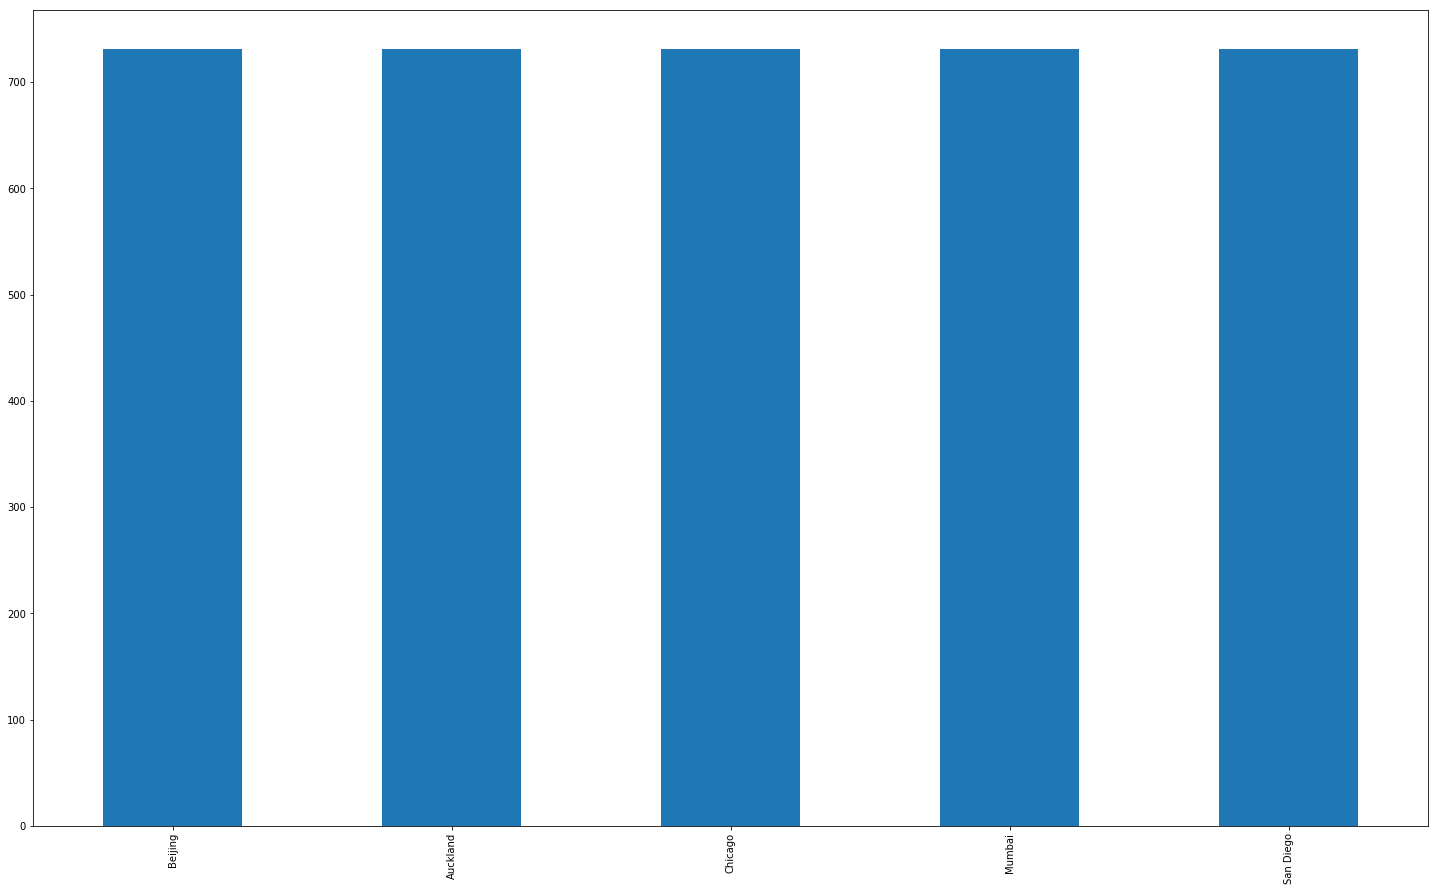

In [35]:
dane.city.value_counts().plot.bar()

Okazuje się, że mamy równą ilość obserwacji z każdego miasta.

# Statystyki

In [36]:
dane.iloc[:, 5:24].describe().round(2)[1:]

high_temp  avg_temp  low_temp  high_dewpt  avg_dewpt  low_dewpt  \
mean      21.85     17.36     12.75       13.31      10.55       7.45   
std        9.55      9.26      9.50        9.81      10.61      11.53   
min      -15.00    -17.22    -25.00      -27.22     -31.11     -33.89   
25%       16.67     13.33      8.33        9.44       6.11       2.22   
50%       22.78     18.89     15.00       15.00      12.78      10.00   
75%       30.00     24.44     18.89       19.44      17.22      15.00   
max       38.89     32.22     28.89       30.00      26.67      26.11   

      high_humidity  avg_humidity  low_humidity  high_hg   avg_hg   low_hg  \
mean          85.23         66.46         46.34  1017.29  1014.68  1012.18   
std           13.29         16.93         20.93     7.56     7.43     7.53   
min           24.00         12.00          4.00   992.21   988.82   984.08   
25%           78.00         57.00         30.00  1012.19  1009.82  1007.11   
50%           88.00         70.00         51.00  1016.25  1014.22  1011.85   
75%           94.00         79.00         63.00  1021.33  1018.96  1016.93   
max          100.00        100.00         94.00  1046.73  1044.36  1043.01   

      high_vis  avg_vis  low_vis  high_wind  avg_wind  max_wind_gust  precip  
mean     20.89    17.05    11.68      26.22     12.01          25.01    2.06  
std      11.25     9.06     9.27      10.86      6.22          21.79   11.09  
min       2.54     0.00     0.00       6.44      1.61           0.00    0.00  
25%      15.24    10.16     2.54      20.92      8.05           0.00    0.00  
50%      25.40    15.24    10.16      24.14      9.66          28.97    0.00  
75%      25.40    25.40    20.32      32.19     14.48          40.23    0.03  
max      48.26    48.26    48.26     206.00     45.06         225.31  322.07

Usunęliśmy nieinformacyjną statystykę count - informowała nas o ilości wierszy dla każdej zmiennej, która jest stała i wynosi tyle co liczba wierszy danych - 3655.

Zauważamy, że średnia temperatura w roku jest dość wysoka. Widocznie są to ciepłe miasta :) Albo statystykę tę zaburzają obserwacje odstające. Widzimy sporą różnicę minimum a pierwszego kwartylem. Może to sugerować, iż są tam obserwacje odstające. Podobnie dla punktu rosy widzimy spore rozbieżności mimnimum a pierwszego kwartyla oraz maksimum a trzeciego kwartyla, wilgotności w przypadku najniższych obserwacji oraz podobnie w przypadku innych zmiennych, przez co podejrzewamy występowanie obserwacji odstających w kolumnach. Możemy zauważyć na tej samej zasadzie wysokie maksimum prędkości wiatru i podmuchów, co sugeruje, że przez któreś miasto przeszła jakaś wichura.

Zobaczmy, ile poszczególnych wydarzeń obserwujemy w konkretnych miastach.

C:\ProgramData\anakio\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.

C:\ProgramData\anakio\lib\site-packages\seaborn\categorical.py:3672: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



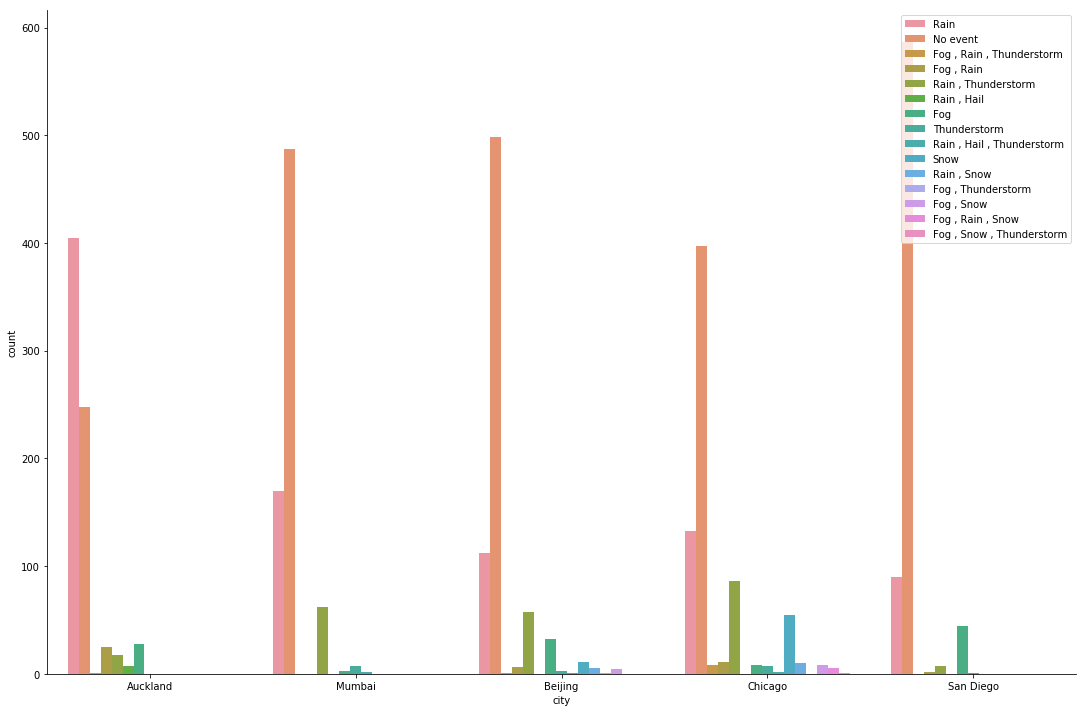

In [37]:
fig = sns.factorplot(x="city", 
                     hue="events", 
                     data=dane, 
                     kind='count',
                     size = 10,
                     aspect = 1.5,
                     legend=False)

fig.ax.legend(loc=1)

Boxplot wykonany przy pomocy biblioteki seaborn, przedstawiający dane średnich temperatur dla poszczególnych miast

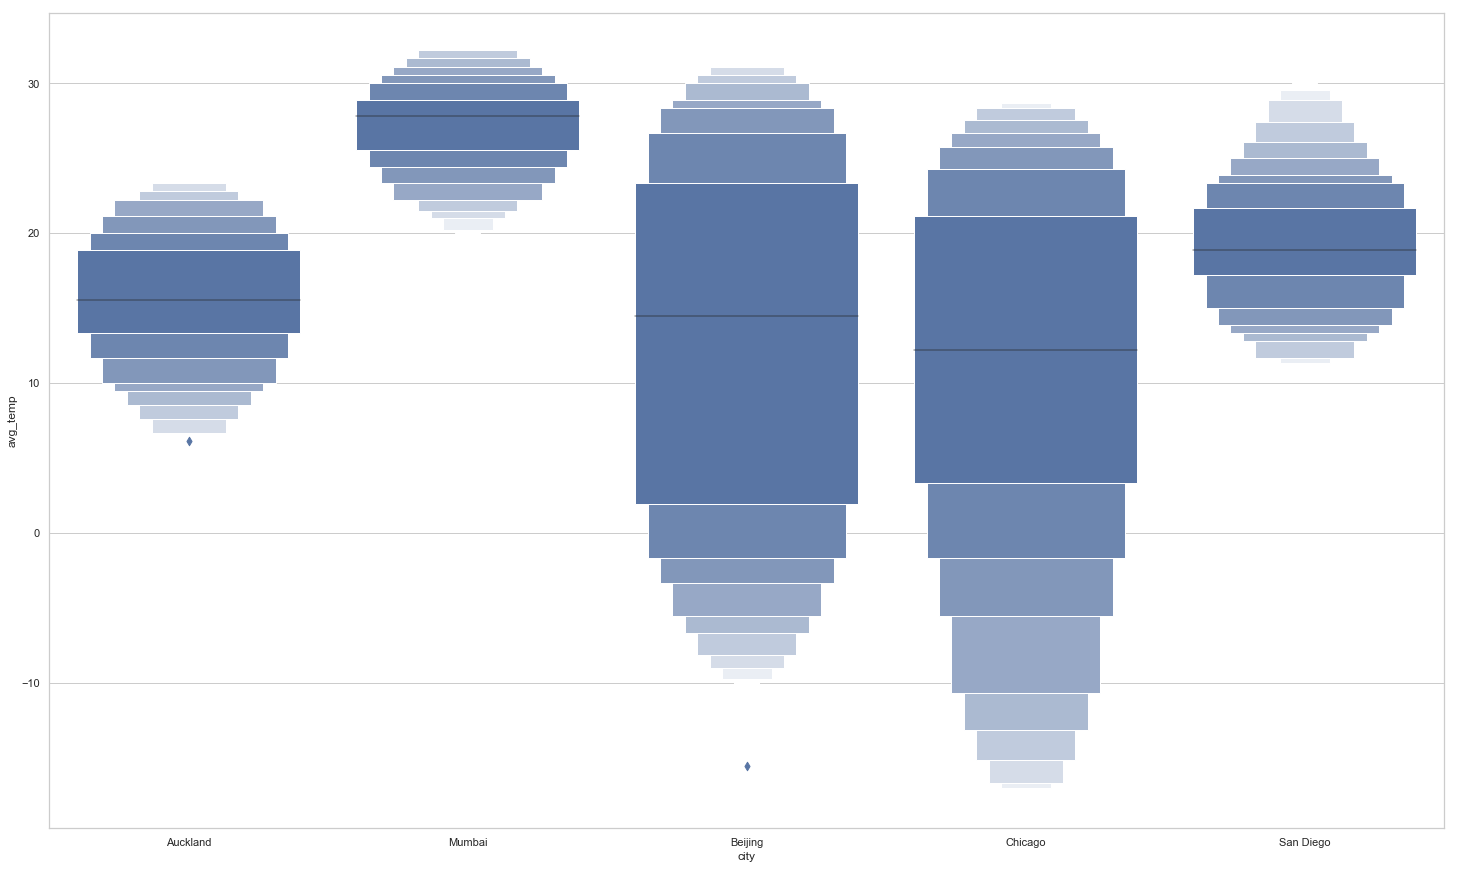

In [38]:
sns.set(style="whitegrid")

sns.boxenplot(x="city", y="avg_temp",
              color="b", 
              scale="linear", data=dane)

Możemy ewidentnie zaobserwować występowanie minimum dwóch obserwacji odstających

Można wywnioskować, że średnie temperatury mają różne zakresy.

Boxplot wykonany przy pomocy biblioteki seaborn, przedstawiający dane średnich temperatur dla poszczególnych zdarzeń

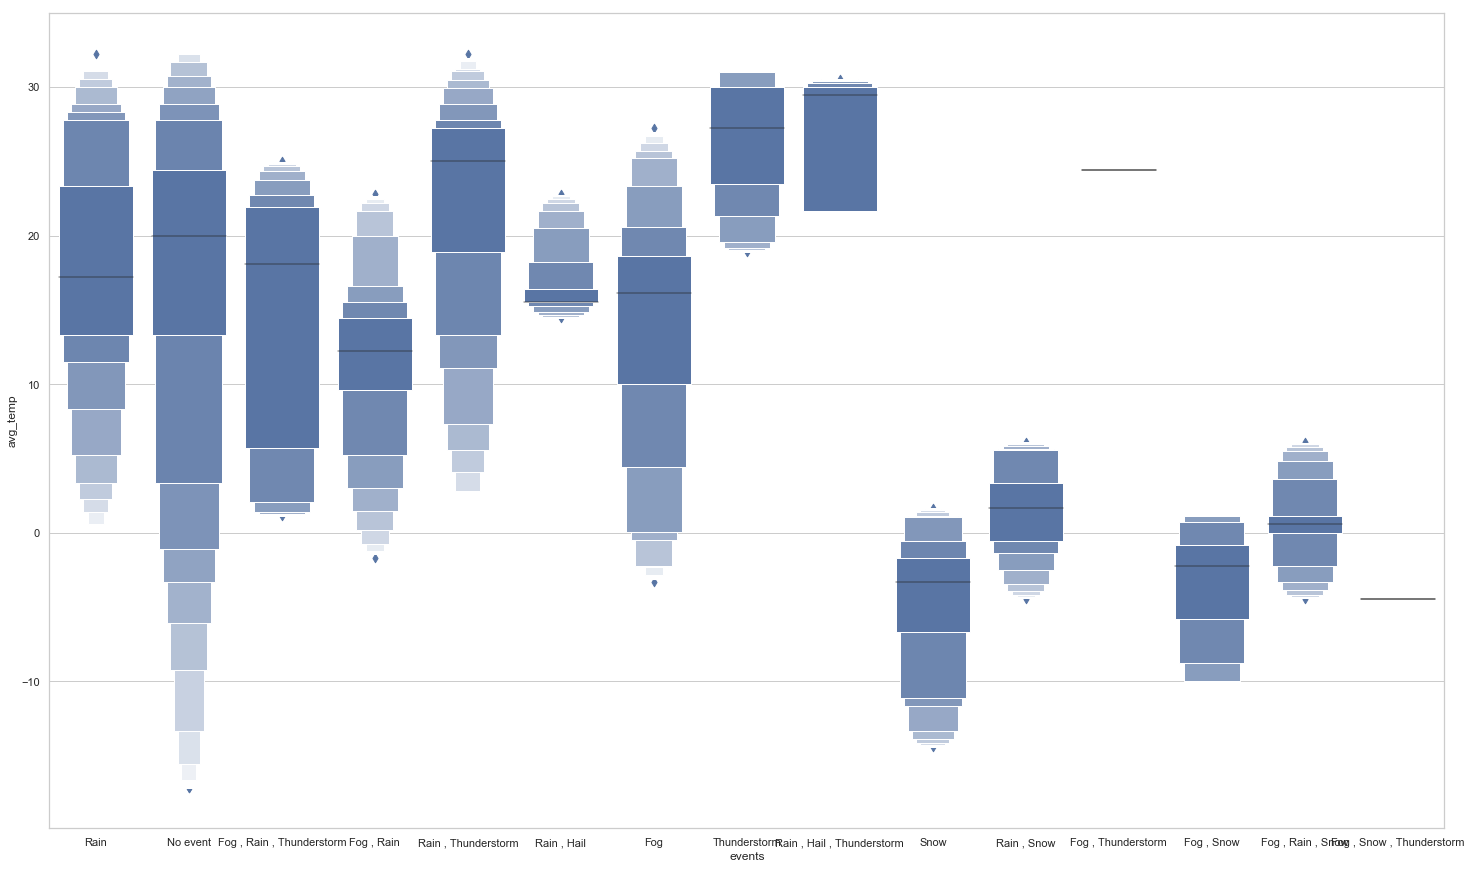

In [40]:
sns.set(style="whitegrid")

sns.boxenplot(x="events", y="avg_temp",
              color="b", 
              scale="linear", data=dane)

W przypadku zdarzeń możemy zaobserwować występowanie minimum dziewiętnastu obserwacji odstających.

In [68]:
y  = {}
trace = []
for ids, city in enumerate(pd.unique(dane.city)):
    y[ids] = dane.avg_temp[dane.city == city]

for city in pd.unique(dane.city):
    trace.append(go.Box(
    y = dane.avg_temp[dane.city == city],
    name = city
    ))
data = trace
py.iplot(data)

C:\ProgramData\anakio\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [47]:
y  = {}
trace = []
for ids, events in enumerate(pd.unique(dane.events)):
    y[ids] = dane.avg_temp[dane.events == events]

for events in pd.unique(dane.events):
    trace.append(go.Box(
    y = dane.avg_temp[dane.events == events],
    name = events
    ))
data = trace
py.iplot(data)

C:\ProgramData\anakio\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



### Wykresy gęstości

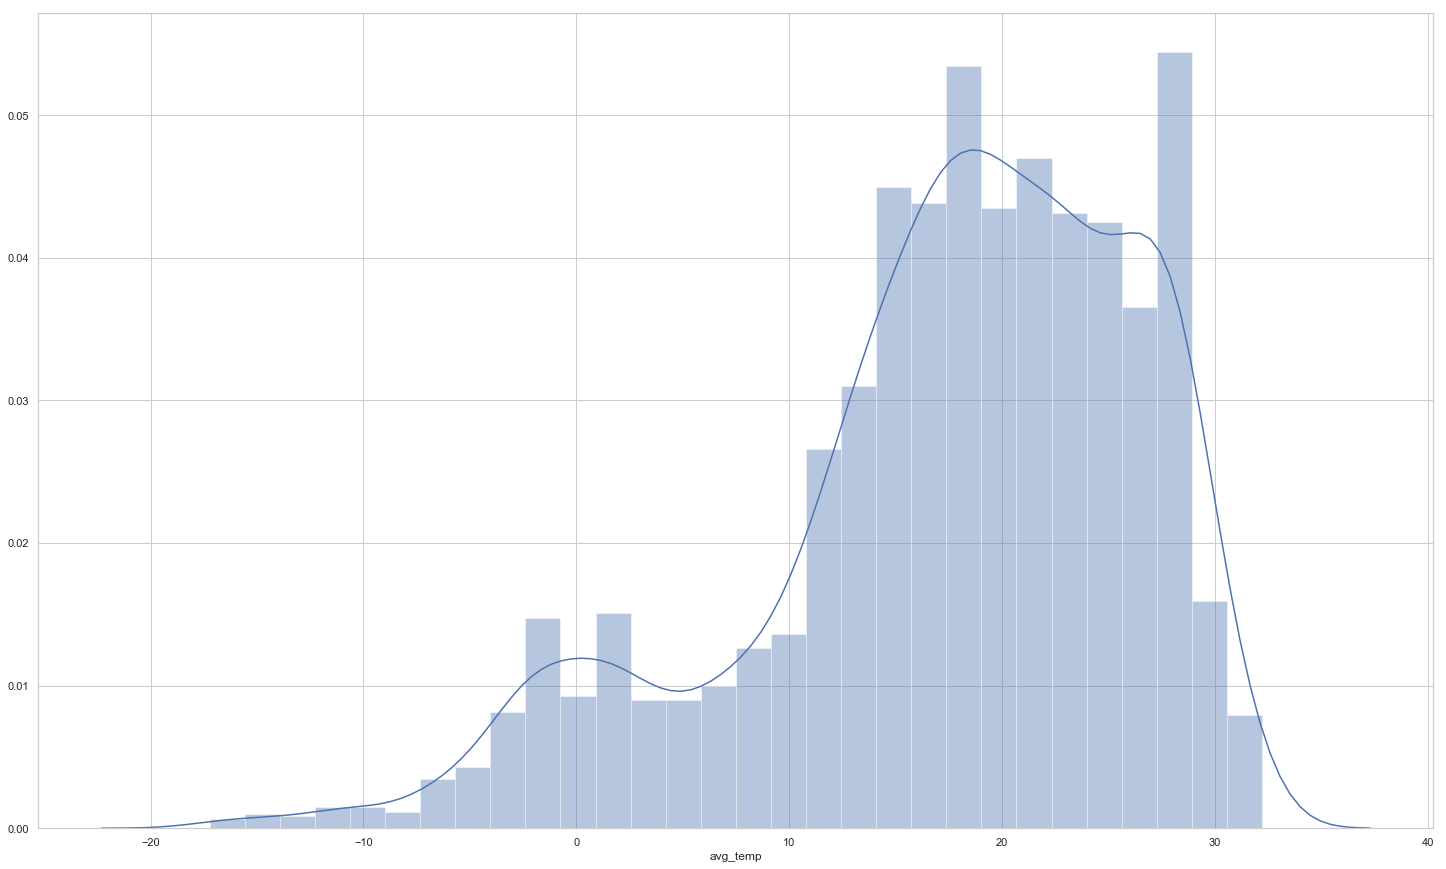

In [48]:
sns.distplot(dane.avg_temp, bins = 30)

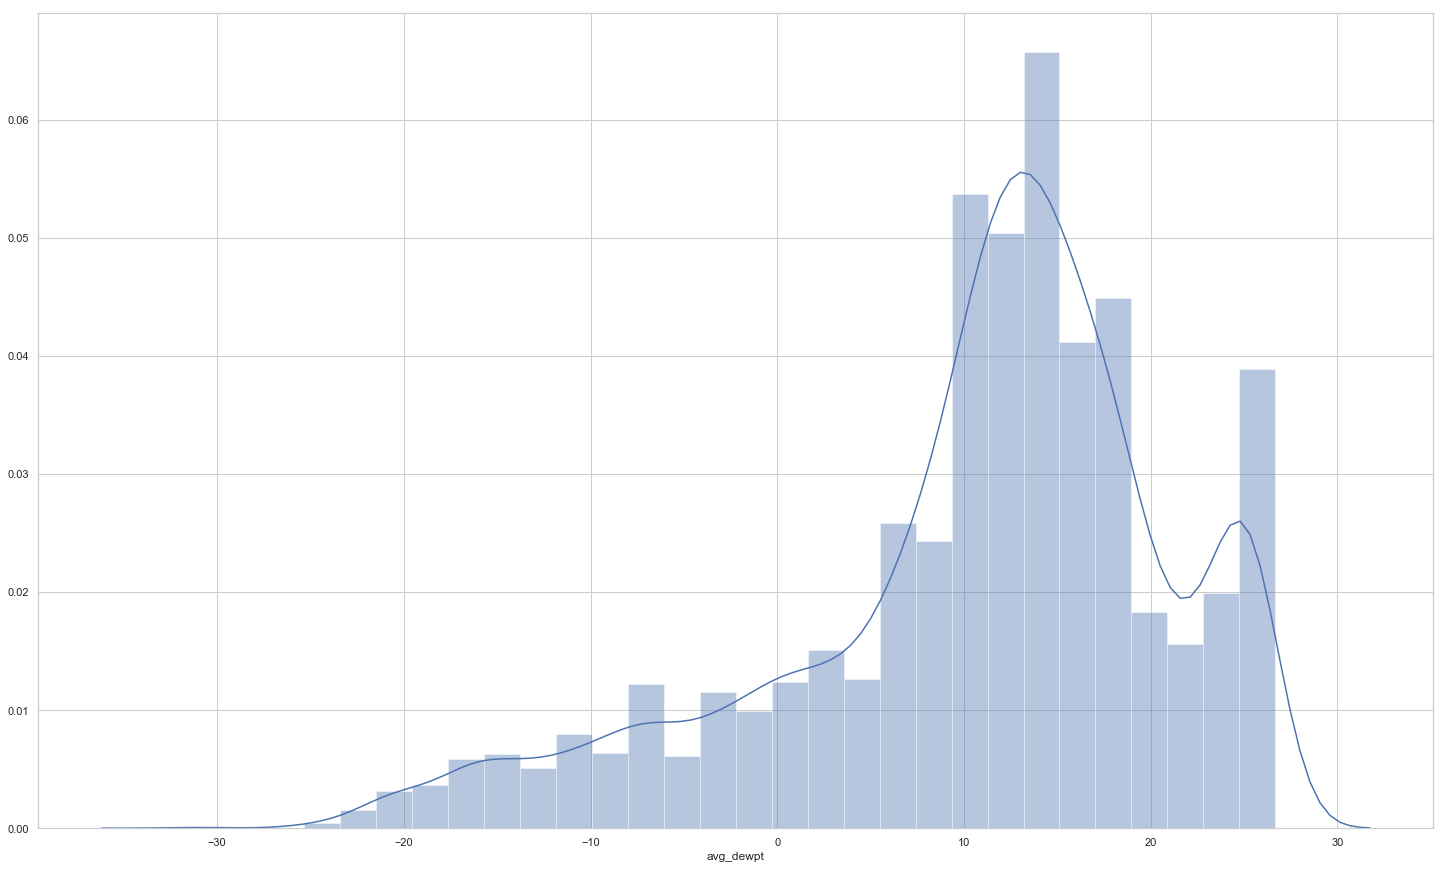

In [49]:
sns.distplot(dane.avg_dewpt, bins = 30)

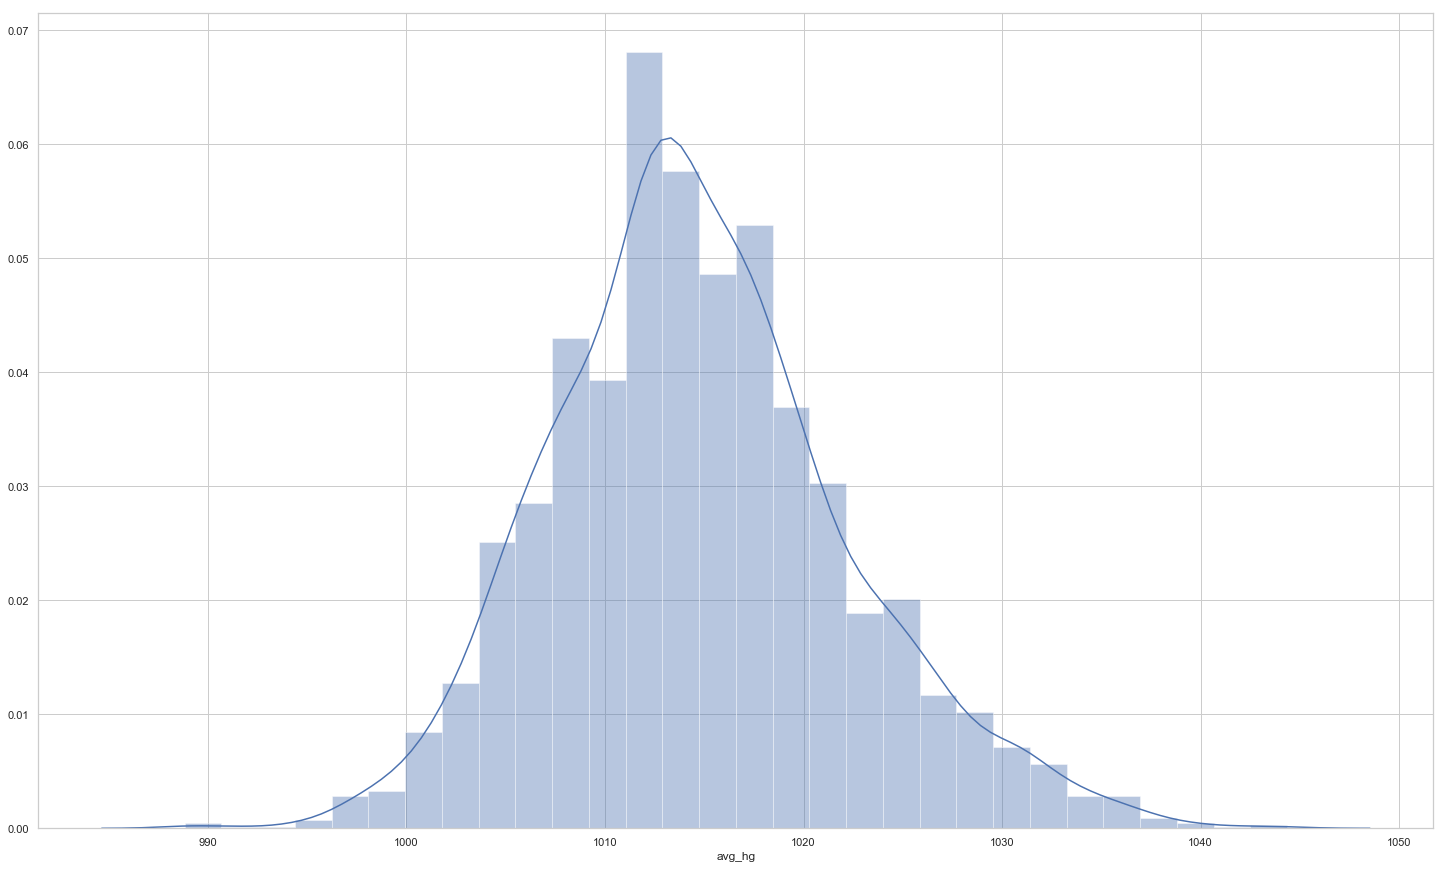

In [50]:
sns.distplot(dane.avg_hg, bins = 30)

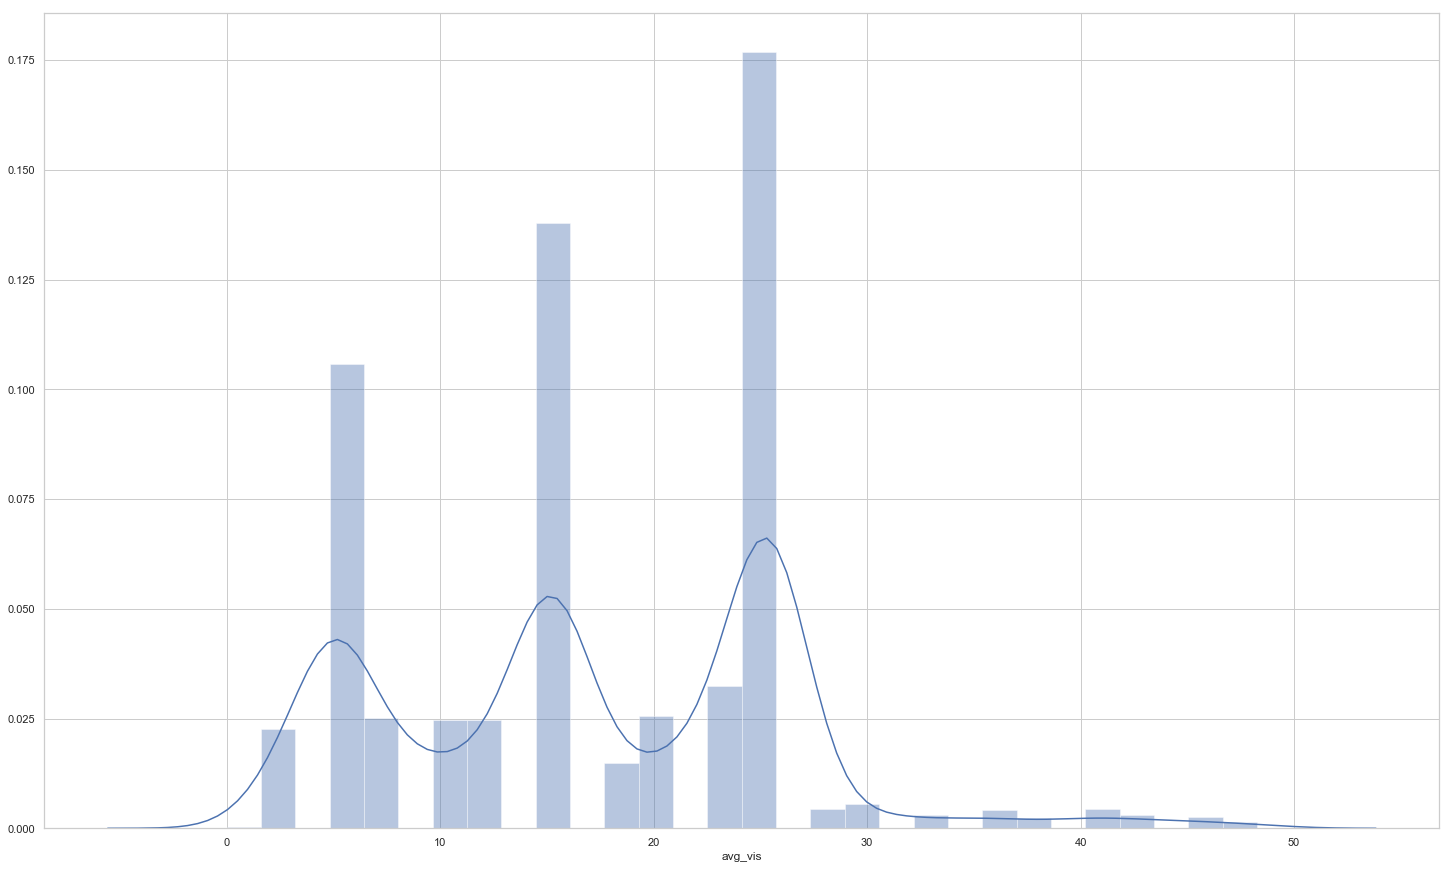

In [51]:
sns.distplot(dane.avg_vis, bins = 30)

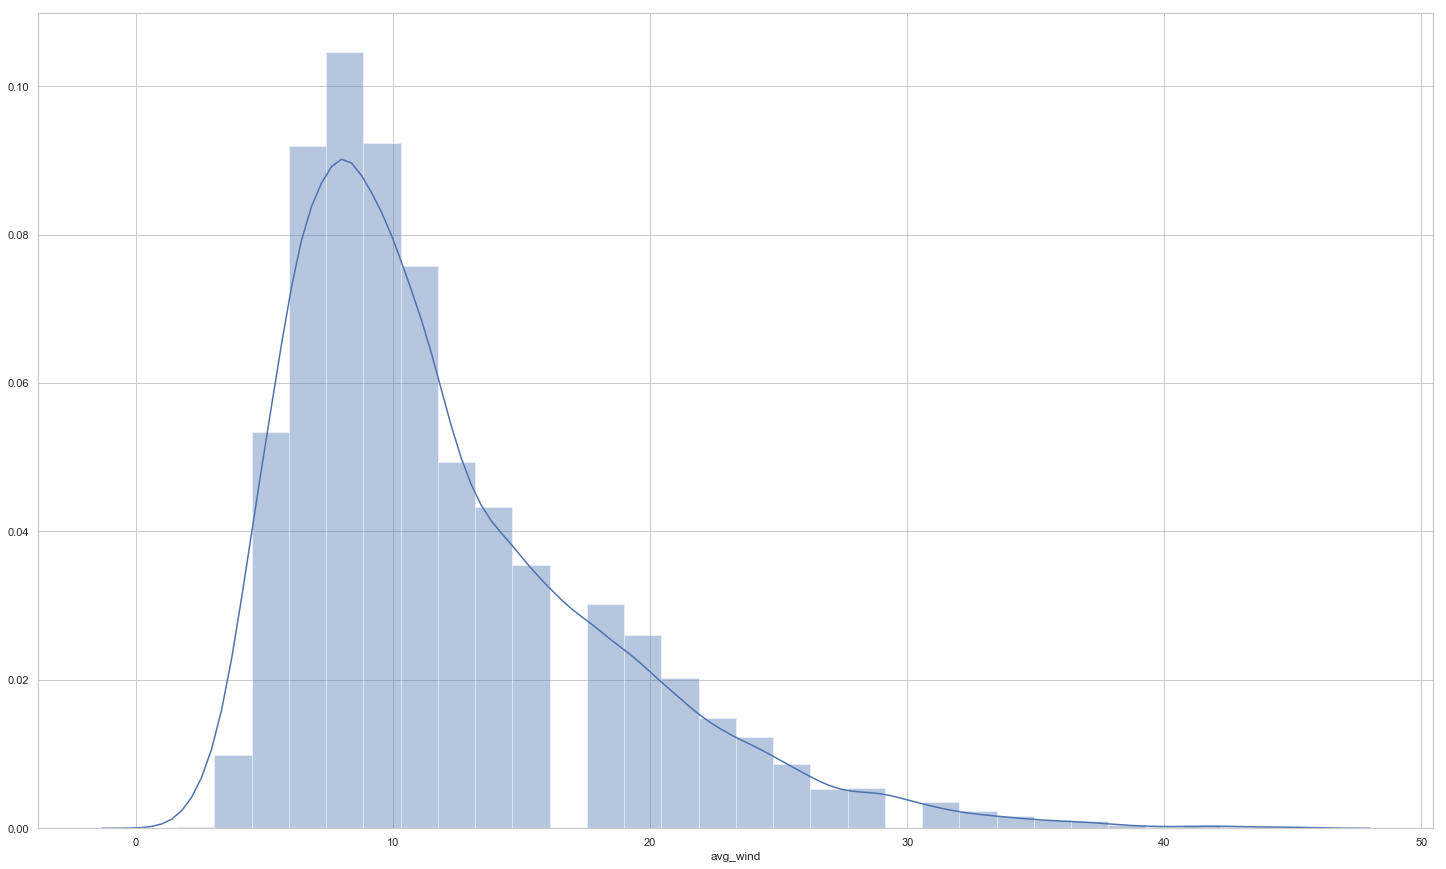

In [52]:
sns.distplot(dane.avg_wind, bins = 30)

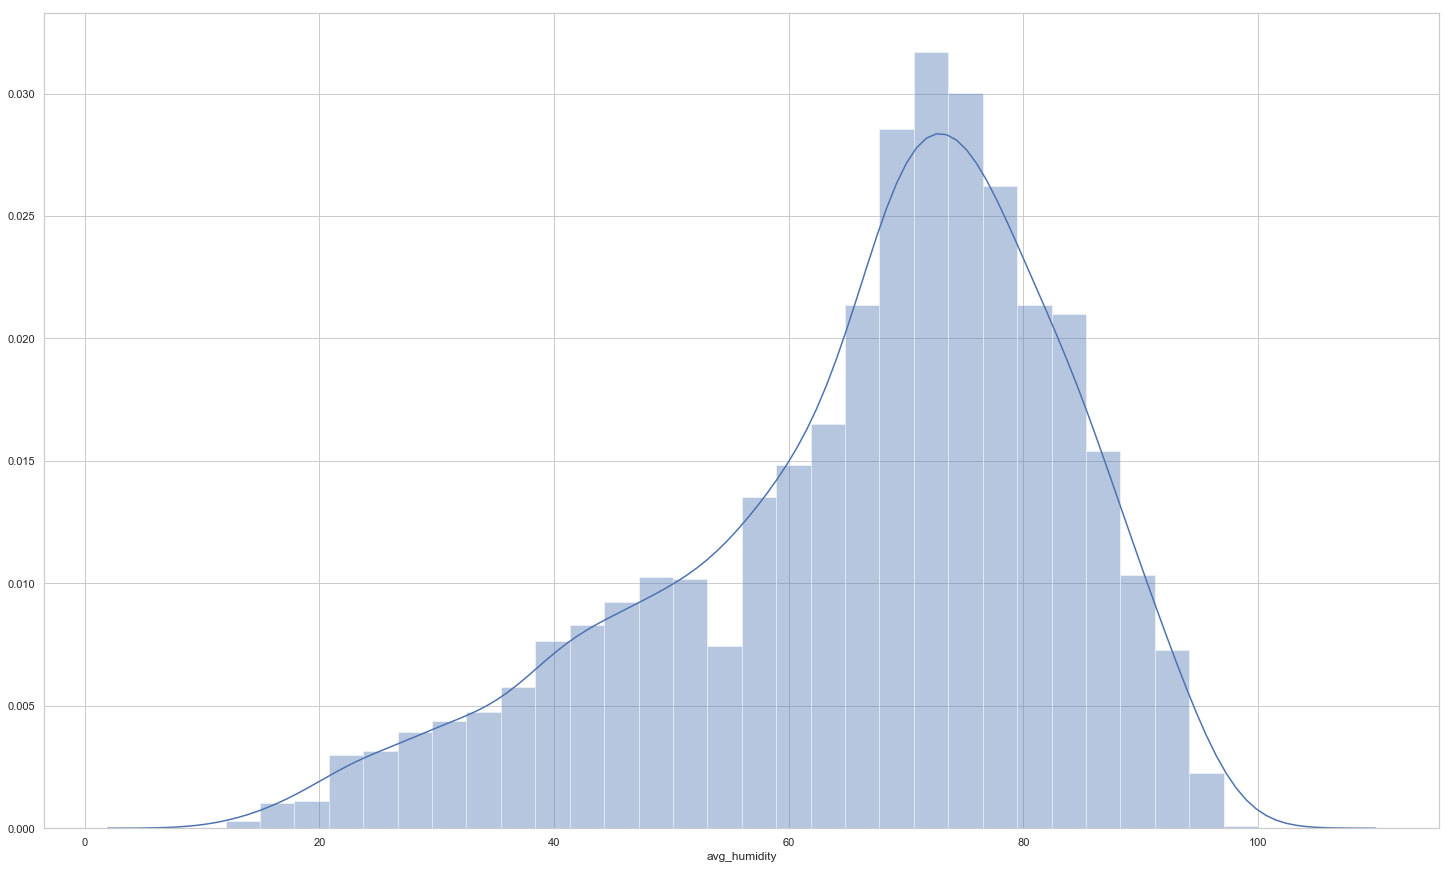

In [53]:
sns.distplot(dane.avg_humidity, bins = 30)

Zwizualizowałyśmy tylko średnie dla poszczególnych zmiennych. Widać, że żadna z cech nie ma rozkładu normalnego, co później sprawdzimy odpowiednimi testami.

Korelacja liniowa cech

In [54]:
dane.iloc[:, 5:25].corr()

high_temp  avg_temp  low_temp  high_dewpt  avg_dewpt  \
high_temp       1.000000  0.973468  0.896853    0.863094   0.819264   
avg_temp        0.973468  1.000000  0.973786    0.929823   0.904736   
low_temp        0.896853  0.973786  1.000000    0.948967   0.943852   
high_dewpt      0.863094  0.929823  0.948967    1.000000   0.982215   
avg_dewpt       0.819264  0.904736  0.943852    0.982215   1.000000   
low_dewpt       0.756047  0.858209  0.916365    0.941952   0.982837   
high_humidity   0.045322  0.119321  0.190195    0.399432   0.440025   
avg_humidity   -0.019281  0.135329  0.283944    0.437810   0.525677   
low_humidity   -0.081429  0.099550  0.274361    0.366775   0.462329   
high_hg        -0.640676 -0.690753 -0.705110   -0.714893  -0.708051   
avg_hg         -0.561986 -0.605038 -0.617150   -0.646974  -0.632459   
low_hg         -0.473933 -0.508575 -0.517192   -0.561641  -0.540544   
high_vis       -0.347900 -0.396188 -0.428421   -0.525034  -0.552806   
avg_vis        -0.350375 -0.359470 -0.357664   -0.487767  -0.487385   
low_vis        -0.201081 -0.189131 -0.174577   -0.309019  -0.289046   
high_wind      -0.159177 -0.133247 -0.102962   -0.098009  -0.113026   
avg_wind       -0.293804 -0.223113 -0.142194   -0.151902  -0.142424   
max_wind_gust  -0.157169 -0.143843 -0.129344   -0.165095  -0.178962   
precip          0.062880  0.099009  0.130543    0.159615   0.163623   

               low_dewpt  high_humidity  avg_humidity  low_humidity   high_hg  \
high_temp       0.756047       0.045322     -0.019281     -0.081429 -0.640676   
avg_temp        0.858209       0.119321      0.135329      0.099550 -0.690753   
low_temp        0.916365       0.190195      0.283944      0.274361 -0.705110   
high_dewpt      0.941952       0.399432      0.437810      0.366775 -0.714893   
avg_dewpt       0.982837       0.440025      0.525677      0.462329 -0.708051   
low_dewpt       1.000000       0.450089      0.581813      0.542278 -0.677375   
high_humidity   0.450089       1.000000      0.821277      0.606416 -0.240563   
avg_humidity    0.581813       0.821277      1.000000      0.923449 -0.295265   
low_humidity    0.542278       0.606416      0.923449      1.000000 -0.278672   
high_hg        -0.677375      -0.240563     -0.295265     -0.278672  1.000000   
avg_hg         -0.595023      -0.248881     -0.286322     -0.268406  0.973715   
low_hg         -0.501079      -0.238699     -0.261393     -0.246094  0.914914   
high_vis       -0.558787      -0.307551     -0.440932     -0.393906  0.349042   
avg_vis        -0.460349      -0.397996     -0.353015     -0.201635  0.355916   
low_vis        -0.250140      -0.399629     -0.250214     -0.084594  0.263206   
high_wind      -0.123472      -0.022699      0.013355      0.091746 -0.066574   
avg_wind       -0.119998      -0.002114      0.125539      0.253916 -0.062517   
max_wind_gust  -0.187347      -0.162970     -0.112508     -0.021387 -0.043010   
precip          0.165420       0.153292      0.203473      0.214677 -0.176191   

                 avg_hg    low_hg  high_vis   avg_vis   low_vis  high_wind  \
high_temp     -0.561986 -0.473933 -0.347900 -0.350375 -0.201081  -0.159177   
avg_temp      -0.605038 -0.508575 -0.396188 -0.359470 -0.189131  -0.133247   
low_temp      -0.617150 -0.517192 -0.428421 -0.357664 -0.174577  -0.102962   
high_dewpt    -0.646974 -0.561641 -0.525034 -0.487767 -0.309019  -0.098009   
avg_dewpt     -0.632459 -0.540544 -0.552806 -0.487385 -0.289046  -0.113026   
low_dewpt     -0.595023 -0.501079 -0.558787 -0.460349 -0.250140  -0.123472   
high_humidity -0.248881 -0.238699 -0.307551 -0.397996 -0.399629  -0.022699   
avg_humidity  -0.286322 -0.261393 -0.440932 -0.353015 -0.250214   0.013355   
low_humidity  -0.268406 -0.246094 -0.393906 -0.201635 -0.084594   0.091746   
high_hg        0.973715  0.914914  0.349042  0.355916  0.263206  -0.066574   
avg_hg         1.000000  0.977425  0.316743  0.353103  0.296694  -0.147148   
low_hg         0.977425  1.000000  0.

Możemy zauważyć wykrytą dużą korelację niektórych zmiennych. Wynika to de facto z opisywania tych samych czynników np średnia temperatura oraz najwyższa i najniższa temperatura.

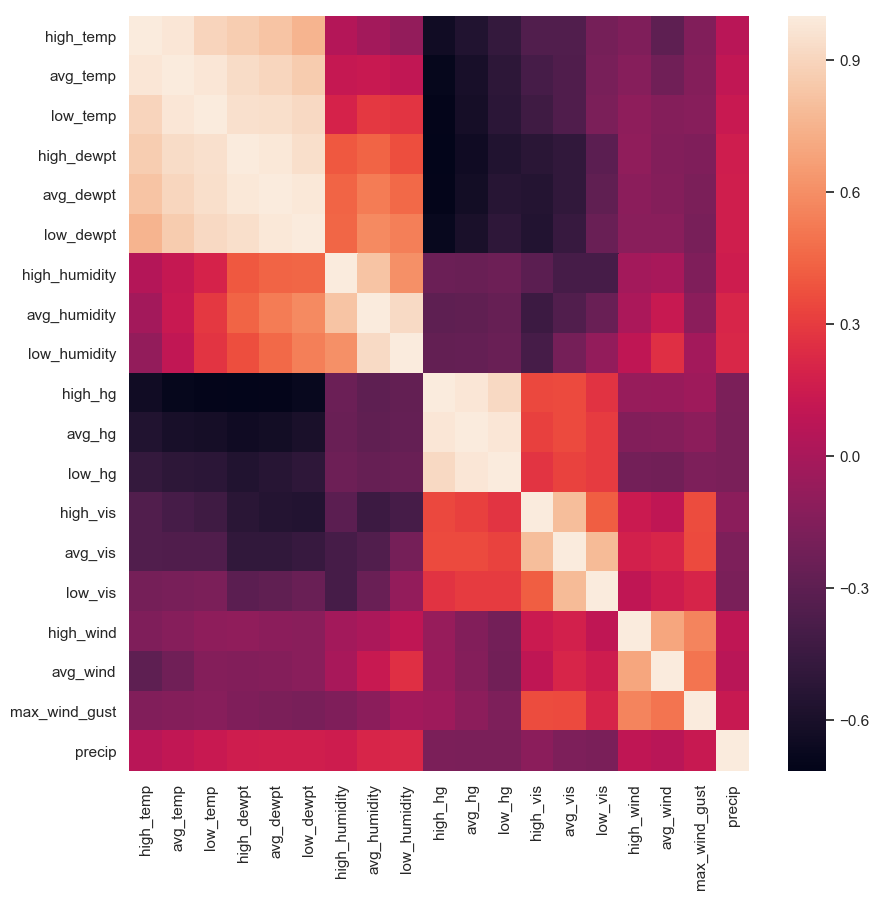

In [55]:
plt.figure(figsize = (10,10), dpi = 100)
fig=sns.heatmap(dane.iloc[:, 5:25].corr())

In [56]:
trace = go.Heatmap(z = dane.iloc[:, 5:25].corr())
data=[trace]
py.iplot(data, filename = 'basic-heatmap')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~iza08.ik/0 or inside your plot.ly account where it is named 'basic-heatmap'


C:\ProgramData\anakio\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



Raport wygenerowany automatycznie z pakietu pandas_profiling

In [57]:
pandas_profiling.ProfileReport(dane)

# Redukcja wymiaru

### Standaryzacja danych numerycznych (odpowiednich kolumn) - przygotowanie danych do PCA

In [58]:
x = dane.iloc[:, 5:24].values
x = StandardScaler().fit_transform(x)

### Inicjacja odpowiedniej klasy i transformacja danych algorytmem PCA

In [59]:
pca = PCA()
principalComponents = pca.fit_transform(x)

Sprawdzenie, w jakim stopniu poszczególne składowe wyjaśniają wariancję pierwotnych zmiennych

In [60]:
pca.explained_variance_ratio_.cumsum()

array([0.44234819, 0.58856209, 0.72695059, 0.80746199, 0.85704549,
       0.90429336, 0.93899708, 0.96088112, 0.97609969, 0.98793315,
       0.99161901, 0.99439932, 0.99605359, 0.99749416, 0.998721  ,
       0.99961845, 0.99982696, 0.99998368, 1.        ])

W przypadku odcięcia na poziomie 0.8 uwzględnilibyśmy 4 składowe, 0.9 - 6 składowych.

Wykres osypiska - wizualne kryterium ilości istotnych składowych

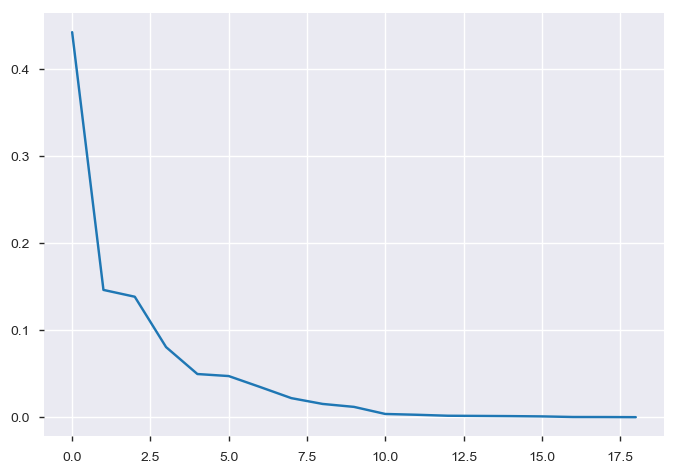

In [61]:
data = pca.explained_variance_ratio_
sns.lineplot(y = data, x = list(range(len(data))))

Patrząc na wykres wybralibyśmy 5 składowych. 

In [62]:
plotly.offline.init_notebook_mode() 
var_exp = pca.explained_variance_ratio_
cum_var_exp = pca.explained_variance_ratio_.cumsum()
trace1 = dict(
    type='bar',
    x=['PC %s' %i for i in range(1,15)],
    y=var_exp,
    name='Wariancja wyjaśniana przez poszczególne składowe'
)

trace3 = dict(
    type='scatter',
    x=['PC %s' %i for i in range(1,15)], 
    y=cum_var_exp,
    name='Skumulowana wyjaśniana wariancja'
)

trace2 = dict(
    type='scatter',
    x=['PC %s' %i for i in range(1,15)], 
    y=var_exp,
    name='Wykres osypiska'
)

data = [trace1, trace2, trace3]

layout = dict(
    title='Wykres osypiska',
    yaxis=dict(
        title='Wyjaśniana wariancja w procentach'
    ),
    legend=dict(x=-.1, y=1.2),
    annotations=list([
        dict(
            x=1.16,
            y=1.05,
            xref='paper',
            yref='paper',
            text='V',
            showarrow=False,
        )
    ])
)

fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig) 

### Wizualizacja zbioru danych

Dopasowanie dwóch składowych w celu wizualizacji

In [63]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

principalDf = pd.DataFrame(data = principalComponents
                           , columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, dane[['events']], dane[['city']]], axis = 1)

Skumulowana wariancja tłumaczona przez pierwsze dwa komponenty

In [64]:
pca.explained_variance_ratio_.cumsum()

array([0.44234819, 0.58856209])

Jak widzimy dwie składowe słabo wyjaśniają ogólną wariancję zmiennych początkowych. Zastosujemy je więc tylko i wyłącznie w celu wizualizacji zbioru.

Wykres rozrzutu pierwszych dwóch składowych PCA wraz z oznaczeniem wydarzeń

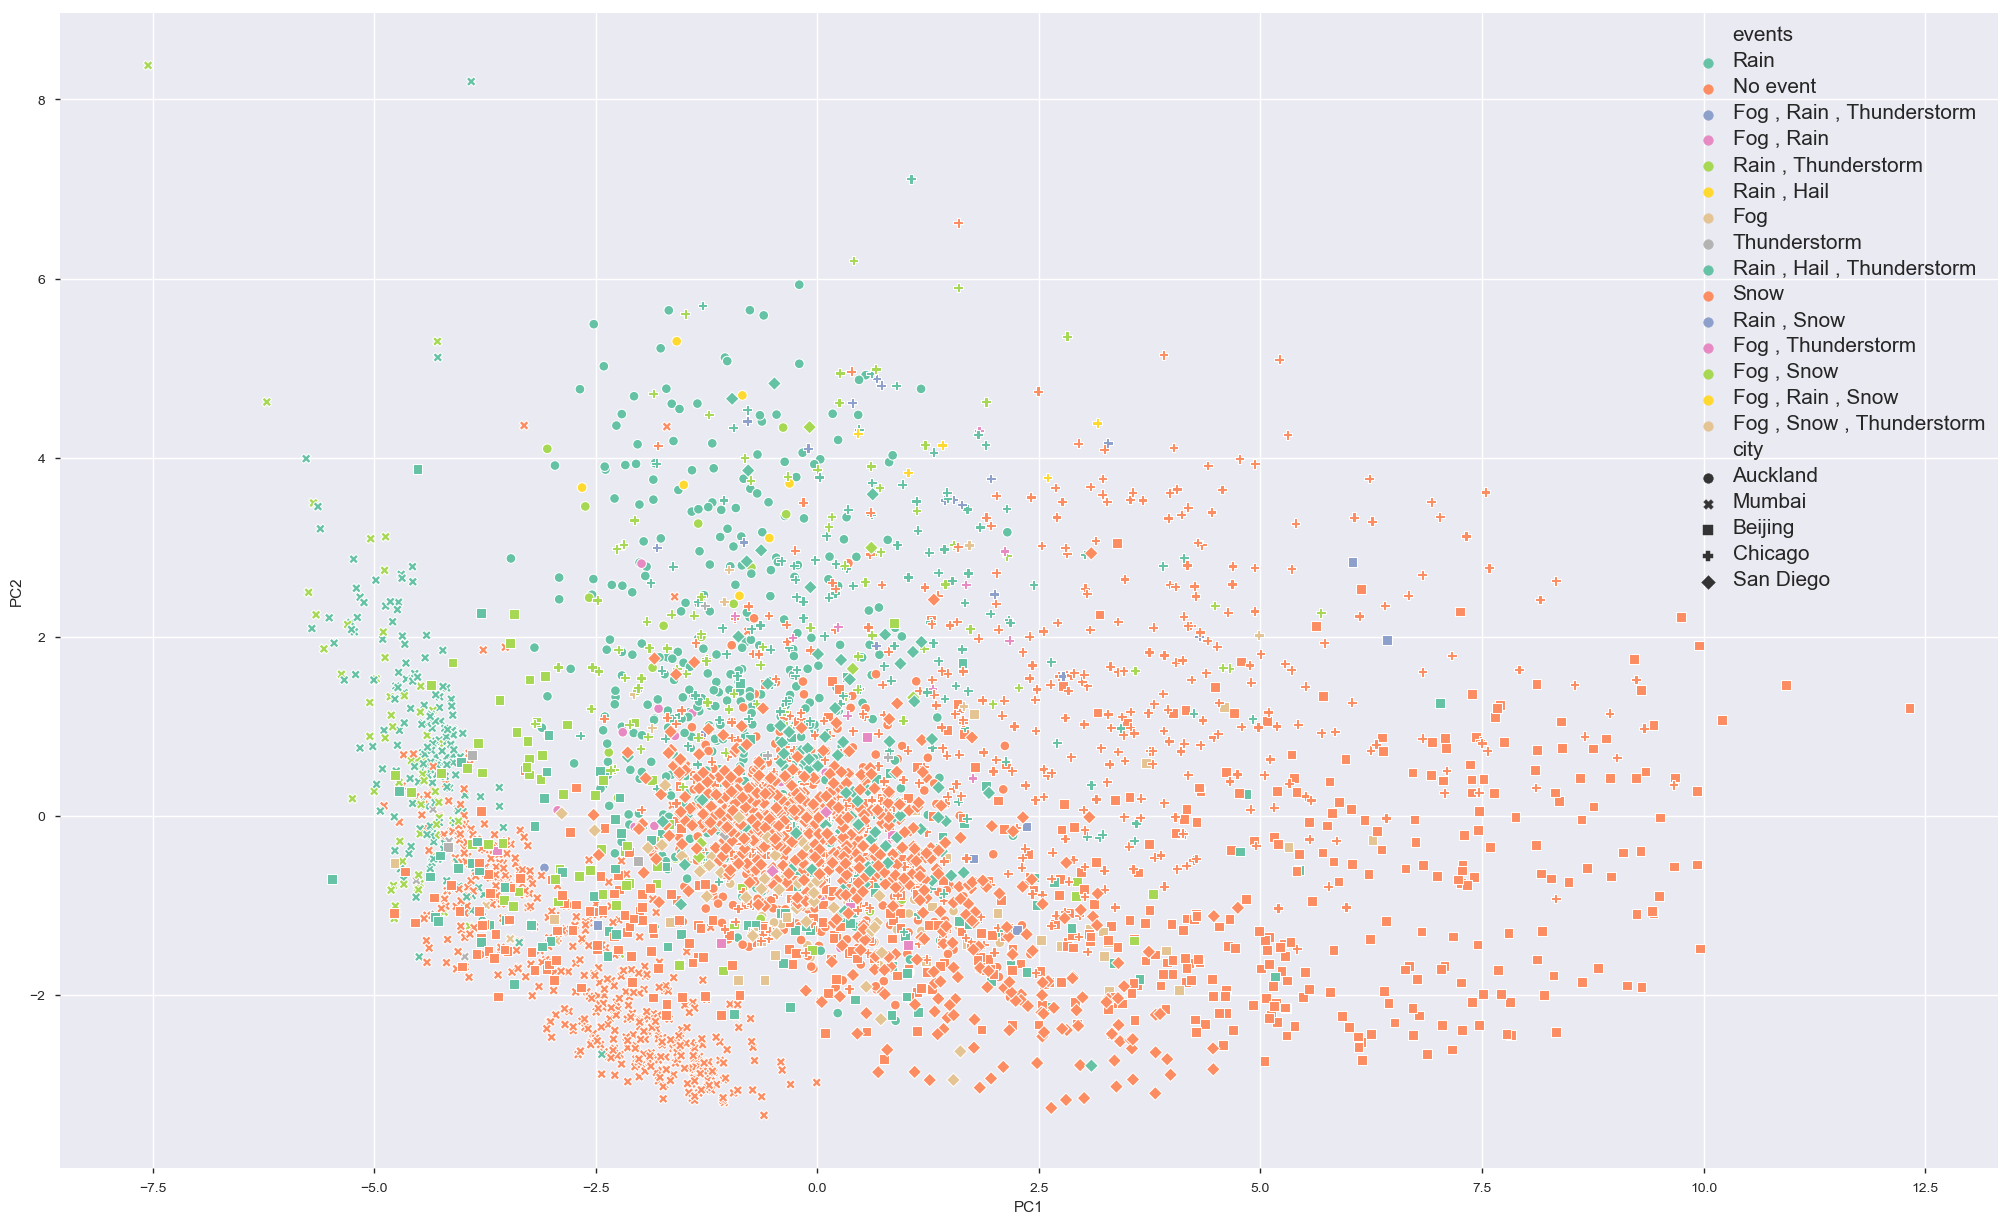

In [69]:
fig = sns.scatterplot(data = finalDf, x = 'PC1', y = 'PC2', hue = dane['events'], palette = 'Set2', style = 'city')
plt.setp(fig.get_legend().get_texts(), fontsize='15')
fig

Możemy zaobserwować, że dane nie są liniowo separowalne. Może wynikać to z nakładania się zdarzeń.

Wykres rozrzutu pierwszych dwóch składowych PCA wraz z oznaczeniem miast

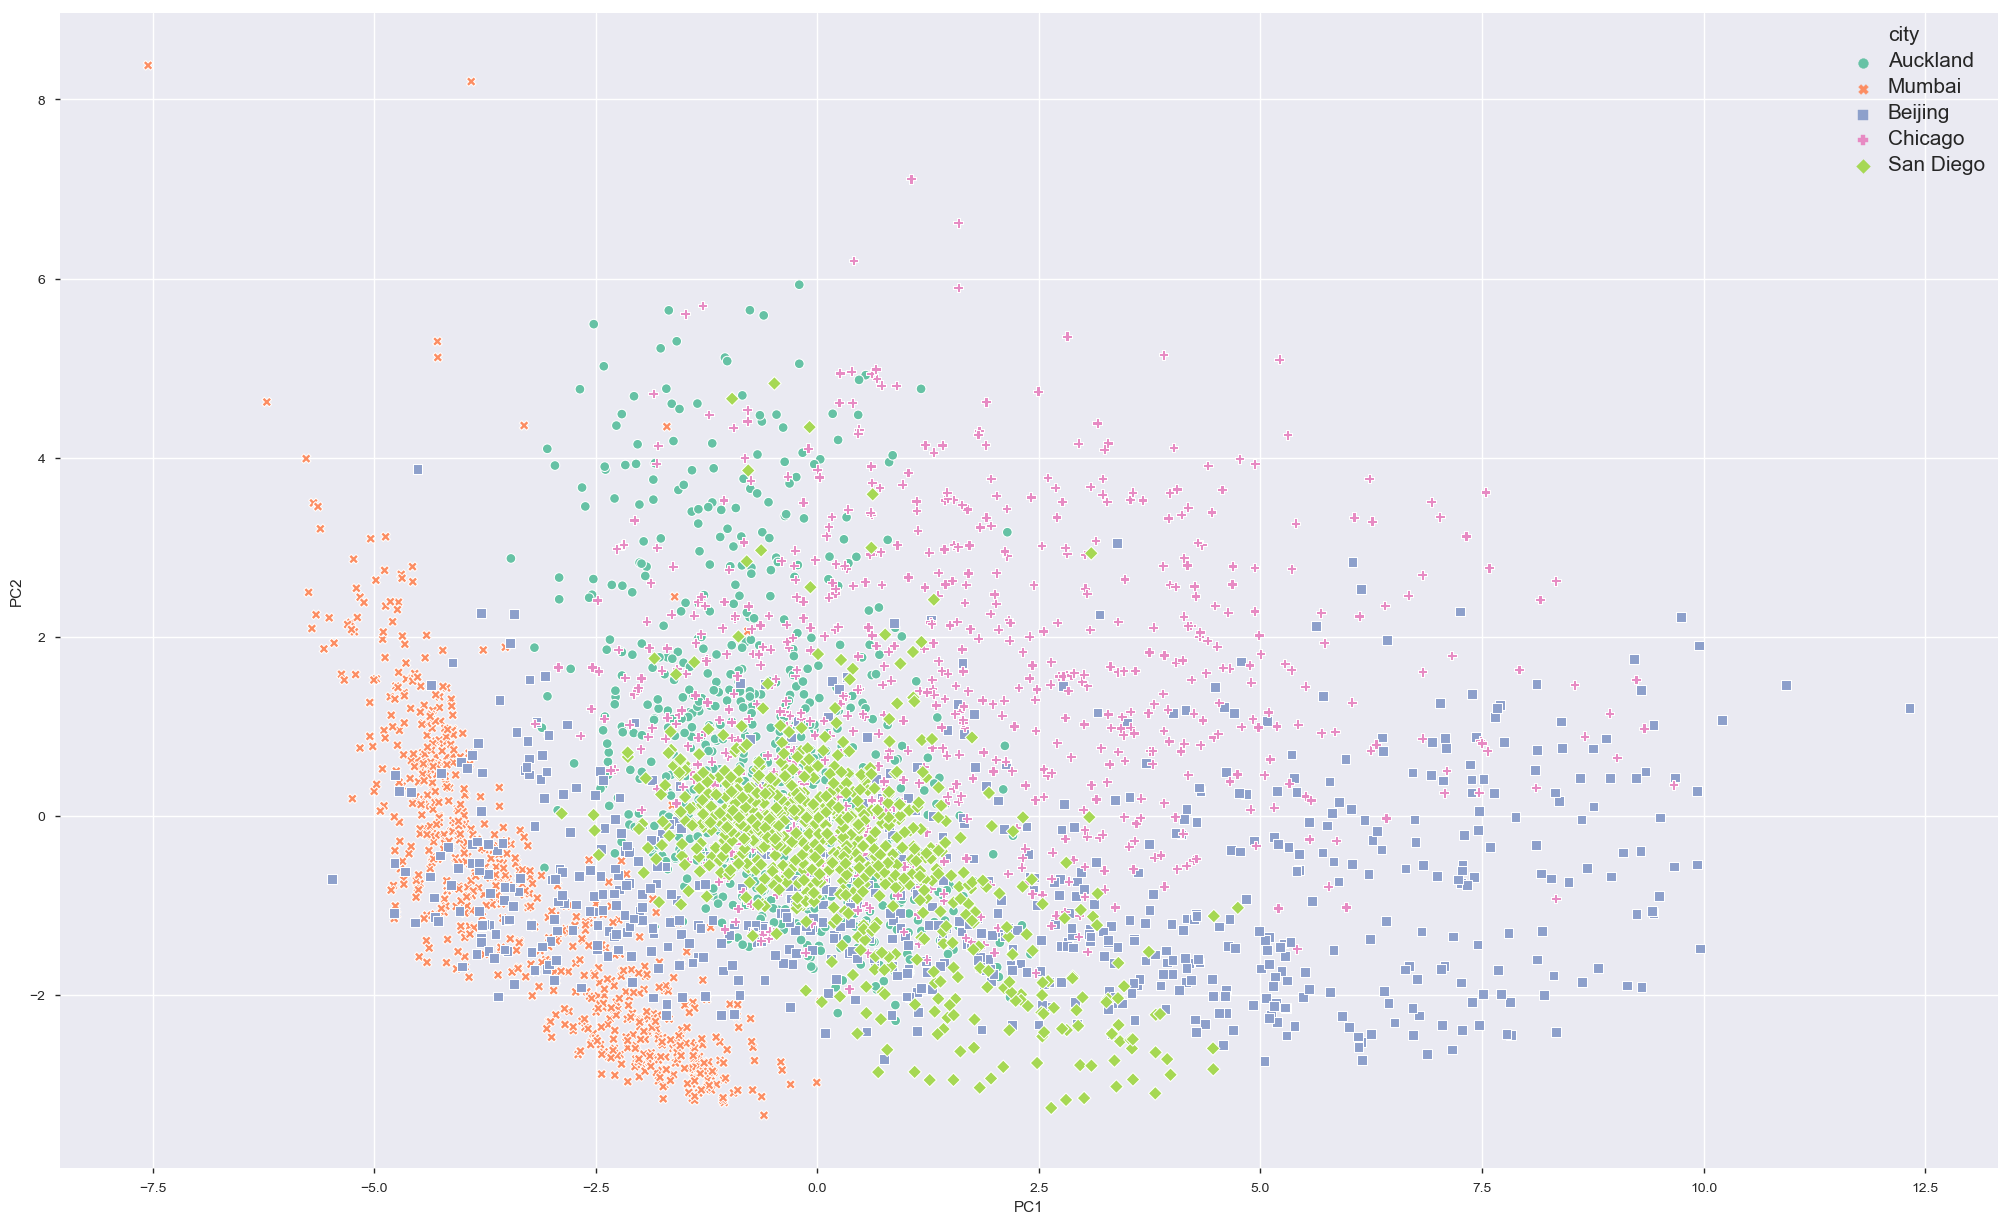

In [66]:
plt.rcParams["figure.figsize"] = (25,15)

fig = sns.scatterplot(data = finalDf, x = 'PC1', y = 'PC2', hue = dane['city'], palette = 'Set2', style = 'city')
plt.setp(fig.get_legend().get_texts(), fontsize='15')
fig

Jak widać dane Mumbaju ewidentnie różnią się od pozostałych. Dane możemy uznać za separowalne według miasta, co daje szansę na sensowną analizę.

# Zapisanie danych do pliku w celu późniejszej analizy

In [67]:
dane.to_csv('../dane/dane.csv', index = False)

czy u werki działo tableau

pairplot